     cost                               request   time  billed_time  memory  \
0     2.0  abfeb743-e977-4194-8d8b-a8b9082f8774  61.35           62     128   
1     2.0  3e28bf0f-68a2-4135-b164-b938f017e893  24.43           25     128   
2     2.0  60ed3eb3-2550-479f-85ef-956d219c2ad8  23.19           24     128   
3     2.0  5021fc63-8336-4e6c-9e4e-1c643866411b  42.67           43     128   
4     2.0  6072225a-87e1-459e-af99-a97b29bd5b08  41.23           42     128   
..    ...                                   ...    ...          ...     ...   
643   2.0  a666878b-fe1e-49f0-a56e-e9f37d3cdb54  25.10           26    2048   
644   2.0  753d5023-9e11-410a-8f8a-1b4331102bba  34.80           35    2048   
645   2.0  4c98c8a2-e070-434d-a761-cd6f04ff1b93  26.65           27    2048   
646   2.0  876bb363-3a16-4c83-b273-82ad4b648d7e  61.28           62    2048   
647   2.0  208b6aae-6bbd-41e4-abd4-1fdf5af0192f  28.18           29    2048   

     used_memory  clients  compute_cost  database_c

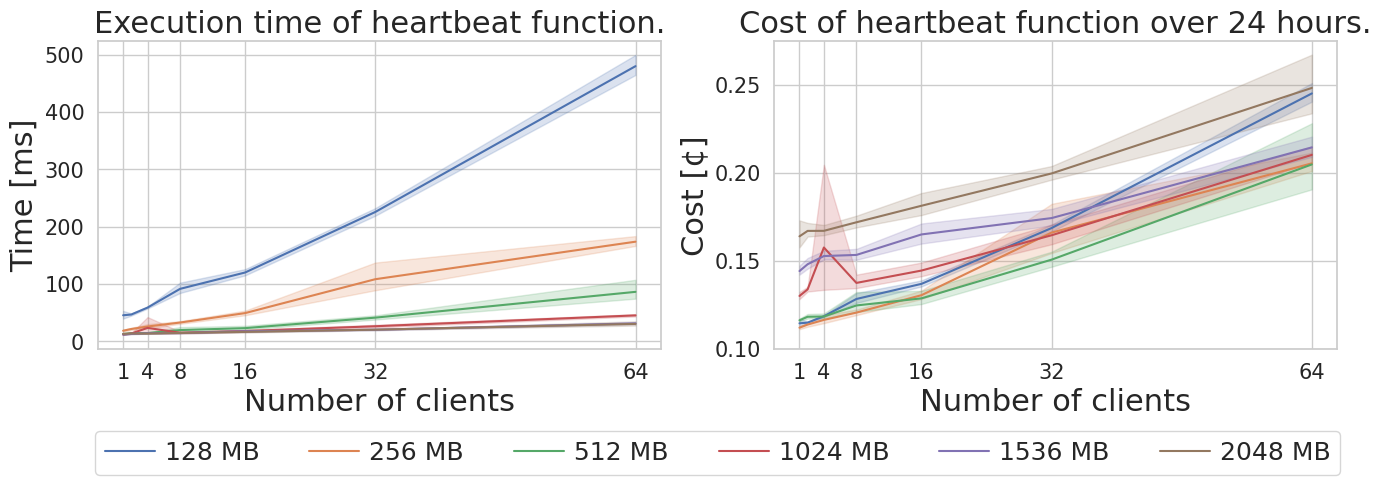

In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

DATA_DIR = join(pardir, pardir, 'data', 'heartbeat')

sns.set(rc={'figure.figsize':(16,4)})
sns.set_style("whitegrid")

fig, axes = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0.2)

# DynamoDB
clients = [1, 2, 4, 8, 16, 32, 64]
dfs = []
for c in clients:
    data = pd.read_csv(join(DATA_DIR, f'benchmark_processed_{c}.csv'), index_col=0)
    data['clients'] = c
    #print(data)
    dfs.append(data)
df = pd.concat(dfs)

# cost (per day)
requests = 60*24
request_cost = 0.20 / 10**6
# per mb-second
duration_cost = 0.0000166667
# dynamodb cost
dynamodb_r_cost = 0.25 / 10**6

df['compute_cost'] = df['billed_time'] * df['memory'] * (duration_cost / 1000) / 1024.0
df['database_cost'] = df['cost'] * dynamodb_r_cost
# convert to cents
df['total_cost'] = df['compute_cost'] * requests + requests * request_cost + df['database_cost'] * requests
df['total_cost'] *= 100
print(df)

sns.lineplot(data=df, x='clients', y='time', hue='memory', ax=axes[0], palette=["C0", "C1", "C2", "C3", "C4", "C5"])#,fontsize=20)
sns.lineplot(data=df, x='clients', y='total_cost', hue='memory', ax=axes[1], palette=["C0", "C1", "C2", "C3", "C4", "C5"])#,fontsize=20)


locs = [2 ** i for i in range(0, 8)]
del locs[1]
axes[0].xaxis.set_major_locator(ticker.FixedLocator(locs))
axes[1].xaxis.set_major_locator(ticker.FixedLocator(locs))
axes[1].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
#axes[0].set_ylim(0, 410)
#axes[0].set_yscale('log')
#axes[1].set_ylim(0, 410)
axes[0].set_xlabel('Number of clients',fontsize=22)
axes[1].set_xlabel('Number of clients',fontsize=22)
axes[0].set_ylabel('Time [ms]',fontsize=22)
axes[1].set_ylabel('Cost [¢]',fontsize=22)
axes[0].set_title('Execution time of heartbeat function.', fontsize=22)
axes[1].set_title('Cost of heartbeat function over 24 hours.', fontsize=22)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[1].set_yticks([0.1, 0.15, 0.2, 0.25])

axes[0].legend().set_visible(False)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, [f"{m} MB" for m in labels], ncol=6, bbox_to_anchor=(-0.10, -0.45), loc='lower center', handletextpad=0.4, fontsize=18)


plt.savefig("performance_plot_new.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

## Cost per client

In [8]:
for group_name, df_group in df.loc[df['memory'] == 1536].groupby(['clients'])['total_cost']:
    #print(group_name
    print(df_group.mean())
    print(df_group.mean() / group_name)
    
    for i in [100, 250, 500, 1000, 2500, 5000, 10000]:
        print(group_name, i, df_group.mean() / group_name * i)

0.11536675340000002
0.11536675340000002
1 100 11.536675340000002
1 250 28.841688350000005
1 500 57.68337670000001
1 1000 115.36675340000002
1 2500 288.41688350000004
1 5000 576.8337670000001
1 10000 1153.6675340000002
0.11922945225688075
0.059614726128440376
2 100 5.961472612844037
2 250 14.903681532110093
2 500 29.807363064220187
2 1000 59.614726128440374
2 2500 149.03681532110093
2 5000 298.07363064220186
2 10000 596.1472612844037
0.12388634230458716
0.03097158557614679
4 100 3.0971585576146787
4 250 7.7428963940366975
4 500 15.485792788073395
4 1000 30.97158557614679
4 2500 77.42896394036697
4 5000 154.85792788073394
4 10000 309.7158557614679
0.12451386649541285
0.015564233311926606
8 100 1.5564233311926605
8 250 3.8910583279816517
8 500 7.7821166559633035
8 1000 15.564233311926607
8 2500 38.910583279816514
8 5000 77.82116655963303
8 10000 155.64233311926606
0.13613957782018346
0.008508723613761466
16 100 0.8508723613761466
16 250 2.1271809034403666
16 500 4.254361806880733
16 1000 